# Introduction

This notebook presents a strategic approach to leveraging models trained in different environments while optimizing GPU quota usage. As many Kaggle competitors are aware, the <span style="font-weight:bold; color:maroon;">30-hour GPU quota</span> can be a significant constraint, particularly when working on high-complexity solutions. This notebook uses the current highest scoring notebook from [Albanito](https://www.kaggle.com/code/albansteff/enefit-estonian-holidays-lb-65-79), and mostly uses the object oriented design from [V. Kudelya](https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt).

### The Challenge of GPU Limitations
In the realm of data science competitions, efficient GPU usage is crucial. High-ranking solutions often demand substantial GPU resources, posing a challenge for those with restricted access.

### A Two-Part Solution
To address this, I propose a two-part process: model development and submission. This approach ensures that GPU resources are utilized solely during the model development phase. The key lies in saving the model in the development phase and then loading it for submission, thereby conserving GPU quota. A second advantage is to have a submission in relatively short time.

### Implementation in Kaggle and Google Colab
While this process is streamlined within the Kaggle environment, it can be extended to other platforms such as Google Colab. 

[In this notebook](https://www.kaggle.com/code/onurrr90/train-lgbm-on-google-colab-to-be-used-in-kaggle/notebook), I detail the steps of training an LGBM model in Google Colab for the Enefit competition followed by its deployment in Kaggle. This involves saving the model as a joblib file and subsequently uploading it as a dataset for import. In another notebook, I explained how to implement a model development notebook on Google Colab that is compatible with Kaggle. There, you can also find more explanation about the reasons of choosing Google Colab and the process to follow there. This notebook only uses the result of that work as a dataset. 

[You can reach this dataset here](https://www.kaggle.com/datasets/onurrr90/enefit-models).

### Navigating Version Incompatibility
A notable challenge arises from version discrepancies between Kaggle and Colab, particularly with LGBM. Direct importing using joblib files can lead to a 'Booster handler error' due to these mismatches. I address this by showcasing a workaround that involves importing the model using joblib, followed by replacing LGBM models with .txt versions for submission.


While experienced Kaggle participants may be familiar with such techniques, this guide is particularly aimed at assisting newcomers. Understanding and applying these practices can significantly enhance your efficiency in competitions, especially when managing limited resources like GPU time.

<h3 style="color: lightcoral;"><strong><em>I hope you will enjoy my notebook. If you find it useful, please consider upvoting.</em></strong></h3>


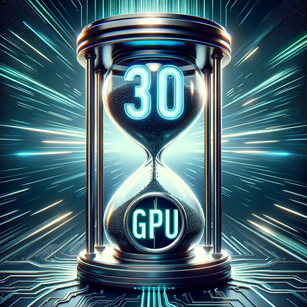

In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import gc
import pickle

import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px

from sklearn.ensemble import VotingRegressor
import lightgbm as lgb


# Classes

### DataStorage

In [2]:
class DataStorage:
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test


### FeaturesGenerator

In [3]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [7 * 24 , 0]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features


# Initialisation

In [4]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)

# Feature Generation

In [5]:
df_train_features = features_generator.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]

In [6]:
import holidays
import datetime

estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
estonian_holidays = list(estonian_holidays.keys())

def add_holidays_as_binary_features(df):
    df['country_holiday'] = df.apply(lambda row: (datetime.date(row['year'], row['month'], row['day']) in estonian_holidays) * 1, axis=1)
    
    return df

df_train_features = add_holidays_as_binary_features(df_train_features)

In [7]:
class Model:
    def __init__(self):
        self.model_parameters = {
            "n_estimators": 2500,
            "learning_rate": 0.06,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 15,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            "device": "gpu"
        }

        self.model_consumption = VotingRegressor(
            [
                (
                    f"consumption_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i),
                )
                for i in range(10)
            ]
        )
        self.model_production = VotingRegressor(
            [
                (
                    f"production_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i),
                )
                for i in range(10)
            ]
        )

    def fit(self, df_train_features):
        mask = df_train_features["is_consumption"] == 1
        self.model_consumption.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
        )

        mask = df_train_features["is_consumption"] == 0
        self.model_production.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
        )

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = self.model_consumption.predict(
            df_features[mask]
        ).clip(0)

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = self.model_production.predict(
            df_features[mask]
        ).clip(0)

        return predictions

# Load Model

In [8]:
from joblib import load

model = load(f'/kaggle/input/enefit-models/model.joblib')

In [9]:
def update_boosters_consumption(voting_regressor):
    for i, (estimator_name, estimator) in enumerate(voting_regressor.named_estimators_.items()):
        model_filename = f'/kaggle/input/enefit-models/saved_models_enefit/consumption_consumption_lgb_{i}.txt'
        new_booster = lgb.Booster(model_file=model_filename)

        if hasattr(estimator, '_Booster'):
            estimator._Booster = new_booster

            
def update_boosters_production(voting_regressor):
    for i, (estimator_name, estimator) in enumerate(voting_regressor.named_estimators_.items()):
        model_filename = f'/kaggle/input/enefit-models/saved_models_enefit/production_production_lgb_{i}.txt'
        new_booster = lgb.Booster(model_file=model_filename)

        if hasattr(estimator, '_Booster'):
            estimator._Booster = new_booster

update_boosters_consumption(model.model_consumption)
update_boosters_production(model.model_production)

# Submit API

In [10]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [11]:
for (
    df_test, 
    df_new_target, 
    df_new_client, 
    df_new_historical_weather,
    df_new_forecast_weather, 
    df_new_electricity_prices, 
    df_new_gas_prices, 
    df_sample_prediction
) in iter_test:

    data_storage.update_with_new_data(
        df_new_client=df_new_client,
        df_new_gas_prices=df_new_gas_prices,
        df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather,
        df_new_historical_weather=df_new_historical_weather,
        df_new_target=df_new_target
    )
    df_test = data_storage.preprocess_test(df_test)
    
    df_test_features = features_generator.generate_features(df_test)
    df_test_features = add_holidays_as_binary_features(df_test_features)
    df_sample_prediction["target"] = model.predict(df_test_features)
    
    env.predict(df_sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
